# Analysis of libjpeg - quality

**Author:** Martin Beneš

This notebook contains forensic analysis of quality compression parameter using various libjpeg versions. Both RGB and grayscale are tested separately. All the other parameters are kept default.

In [1]:
# versions to test
versions = ['6b','turbo210','7','8','8a','8b','8c','8d','9','9a','9b','9c','9d','9e']
qualities = list(range(0,101))

# default versions
import jpeglib
v_arbitrary = '9e' # arbitrary version
jpeglib.version.set(v_arbitrary)

# random subsample size
N_samples = 10

# database path
from pathlib import Path
db_path = Path.home() / 'Datasets'

# checkerboard
import numpy as np
def checkerboard(boardsize, tilesize, channels=3):
    board = np.zeros([*boardsize, channels], dtype=np.uint8)
    for i in range(boardsize[0]):
        for j in range(boardsize[1]):
            if (i//tilesize[0]) % 2 == (j//tilesize[1]) % 2:
                board[i,j] = 255
    return board

## Load BOSS

Load BOSSBase database consisting of 10000 grayscale images. It can be downloaded [here](http://agents.fel.cvut.cz/boss/index.php?mode=VIEW&tmpl=materials). For faster execution, we only work with its subsample.

In [2]:
# list BOSS database
import os
boss_path = db_path / 'BOSS_raw' / 'BOSS_from_raw'
boss_names = [boss_path / f for f in os.listdir(boss_path)]
print("Loaded BOSS database with", len(boss_names), "images.")

# sample without replacement
import random
random.seed(42) # answer to everything
boss_names_sub = random.sample(boss_names, N_samples-2)

# choose most and least saturated
#import cv2
#most,least = (None,0),(None,0)
#for i,f in enumerate(boss_names):
#    if i % 500 == 0: print(i, '/', len(boss_names), '         ', end='\r')
#    if str(f).split('.')[-1] != 'png': continue
#    x = cv2.imread(str(f),cv2.IMREAD_GRAYSCALE)
#    xmin,xmax = (x == 0).sum(),(x == 255).sum()
#    if xmin > least[1]: least = (f,xmin)
#    if xmax > most[1]: most = (f,xmax)
most,least = (boss_path / '6900_1_3.png',262144),(boss_path / '6155_1_6.png', 88944)
# add them
boss_names_sub.append(most[0])
boss_names_sub.append(least[0])

# load the grayscale image with cv2
import cv2
import numpy as np
boss = np.array([np.array(cv2.imread(str(f),cv2.IMREAD_GRAYSCALE)) for f in boss_names_sub])
boss = np.expand_dims(boss, axis=3)

# append checkerboard
for tilesize in [(4,4),(7,7),(8,8),(15,15),(16,16)]:
    boss = np.append(boss, np.expand_dims(checkerboard((512, 512), tilesize, channels=1), 0), 0)

print("Input shape", boss.shape)

Loaded BOSS database with 23152 images.
Input shape (15, 512, 512, 1)


## Load ALASKA

Load ALASKA2 database consisting of 70000 colored images. In this case we have uncompressed version of shape 256x256. You can find the scripts to download it [here](https://alaska.utt.fr/).

In [3]:
# Load ALASKA2 database
alaska_path = db_path / 'ALASKA_v2_TIFF_256_COLOR'
alaska_names = [alaska_path / f for f in os.listdir(alaska_path)]
print("Loaded ALASKA2 database with", len(alaska_names), "images.")

# sample without replacement
random.seed(42) # answer to everything
alaska_names_sub = random.sample(alaska_names, N_samples-2)

# choose most and least saturatedabs
import matplotlib.pyplot as plt
#most,least = (None,0),(None,0)
#for i,f in enumerate(alaska_names):
#    if i % 500 == 0: print(i, '/', len(alaska_names), '         ', end='\r')
#    if str(f).split('.')[-1] != 'tif': continue
#    x = plt.imread(str(f))
#    xmin,xmax = (x == 0).sum(),(x == 255).sum()
#    if xmin > least[1]: least = (f,xmin)
#    if xmax > most[1]: most = (f,xmax)
most,least = (alaska_path / '10343.tif',98491),(alaska_path / '05887.tif', 78128)
# add them
alaska_names_sub.append(most[0])
alaska_names_sub.append(least[0])

# load the image with PIL
import matplotlib.pyplot as plt
alaska = np.array([plt.imread(f) for f in alaska_names_sub])

# append checkerboard
for tilesize in [(4,4),(7,7),(8,8),(15,15),(16,16)]:
    alaska = np.append(alaska, np.expand_dims(checkerboard((256, 256), tilesize, 3), 0), 0)

print("Input shape", alaska.shape)

Loaded ALASKA2 database with 80004 images.
Input shape (15, 256, 256, 3)


## Colored images

### Compression

As first we compress our randomly chosen subsamples by each version. For decompression we use one, arbitrary version to remove the potential artifacts from decompression mismatch.

In [4]:
# images recompressed by each version
import tempfile
images_rgb_c = {'version': [], 'quality': [], 'image': [], 'Y': [], 'Cb': [], 'Cr': []}

with tempfile.TemporaryDirectory() as tmp:
    
    # iterate versions
    for i,v_compress in enumerate(versions):
        
        # iterate quality
        for quality in qualities:
        
            # compress each image with version
            fnames = [str(Path(tmp) / f'{i}.jpeg') for i in range(alaska.shape[0])]
            with jpeglib.version(v_compress):
                for i,fname in enumerate(fnames):
                    im = jpeglib.from_spatial(alaska[i])
                    im.write_spatial(fname, qt=quality, flags=['+DO_FANCY_UPSAMPLING'])
        
            # decompress with single (arbitrary) version
            with jpeglib.version(v_arbitrary):
                images_rgb_c['version'].append(v_compress)
                images_rgb_c['quality'].append(quality)
                images_rgb_c['image'].append(np.array([
                    jpeglib.read_spatial(fname, flags=['+DO_FANCY_UPSAMPLING']).spatial for fname in fnames
                ]))
                images_rgb_c['Y'].append([
                    jpeglib.read_dct(fname).Y for fname in fnames
                ])                
                images_rgb_c['Cb'].append([
                    jpeglib.read_dct(fname).Cb for fname in fnames
                ])
                images_rgb_c['Cr'].append([
                    jpeglib.read_dct(fname).Cr for fname in fnames
                ])

# dataframe
import pandas as pd
images_rgb_c = pd.DataFrame(images_rgb_c)

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

### N-to-N comparison

Next we compare each version with each in spatial domain and construct distance matrix (triangular, as it is symmetric).

In [5]:
# distance metric (based on L1)
from scipy.spatial.distance import pdist, squareform
mismatch = lambda x1,x2: (np.abs(x1.astype(np.int32) - x2.astype(np.int32)) != 0).mean()

# images to distance matrix
distmats_rgb_c = {}
for quality in qualities:
    print(quality, end=" ")
    images_rgb_c_ = images_rgb_c[images_rgb_c.quality == quality]
    
    images_rgb_c_list = np.array([list(i) for i in images_rgb_c_.image.to_list()], dtype=object)
    images_rgb_c_list = images_rgb_c_list.reshape(len(versions), -1)
    dists_rgb_c = pdist(images_rgb_c_list, mismatch)
    distmats_rgb_c[quality] = squareform(dists_rgb_c)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

We also need to compare DCT representations to validate, that compression and decompression artifacts did not removed themselves.

In [6]:
mismatch = lambda x1,x2: (np.abs(x1.astype(np.int32) - x2.astype(np.int32)) != 0).mean()
def get_distmat_dct(dct):
    # images to distance matrix
    images_dct_list = np.array([list(i) for i in dct.to_list()], dtype=object)
    images_dct_list = images_dct_list.reshape(len(versions), -1)
    dists_dct = pdist(images_dct_list, mismatch)
    distmat_dct = squareform(dists_dct)
    return distmat_dct

# images to distance matrix
distmats_Y_c = {}
distmats_Cb_c = {}
distmats_Cr_c = {}
for quality in qualities:
    images_rgb_c_ = images_rgb_c[images_rgb_c.quality == quality]
    
    distmats_Y_c[quality] = get_distmat_dct(images_rgb_c_.Y)
    distmats_Cb_c[quality] = get_distmat_dct(images_rgb_c_.Cb)
    distmats_Cr_c[quality] = get_distmat_dct(images_rgb_c_.Cr)
    
    # check match with spatial
    print(
        quality,
        ((distmats_rgb_c[quality] == 0) == (distmats_Y_c[quality] == 0)).all(),
        ((distmats_rgb_c[quality] == 0) == (distmats_Cb_c[quality] == 0)).all(),
        ((distmats_rgb_c[quality] == 0) == (distmats_Cr_c[quality] == 0)).all(),
    )

0 False True False
1 False True False
2 False False True
3 False True False
4 False True True
5 False True True
6 False True True
7 False True True
8 False True True
9 False True True
10 False True True
11 False True True
12 False True True
13 False True True
14 False True True
15 False True True
16 False True True
17 False True True
18 False True True
19 False True True
20 False True True
21 False True True
22 False True True
23 False True True
24 False True True
25 False True True
26 False True True
27 False True True
28 False True True
29 False True True
30 False True True
31 False True True
32 False True True
33 False True True
34 False True True
35 False True True
36 False True True
37 False True True
38 False True True
39 False True True
40 False True True
41 False True True
42 False True True
43 False True True
44 False True True
45 False True True
46 False True True
47 False True True
48 False True True
49 False True True
50 False True True
51 False True True
52 False True True

DCT representation shows the same mismatches as RGB representation.

### Clustering

In the next step we find clusters, corresponding to distinct implementations, which in this configuration produce different results.

In [7]:
# cluster rgb
from sklearn.cluster import AgglomerativeClustering
for quality in qualities:
    for k in range(1,6):
        agnes = AgglomerativeClustering(n_clusters=k, linkage='average', affinity='precomputed')
        agnes.fit(distmats_rgb_c[quality])
    
        # compute heterogenity metric (sum of distances)
        heterogenity = np.sum([ distmats_rgb_c[quality][i,j]
                 for group in np.unique(agnes.labels_)
                 for i in np.where(agnes.labels_ == group)[0]
                 for j in np.where(agnes.labels_ == group)[0] ])
    
        # homogenous clusters
        if heterogenity == 0: break
    print("quality %d:" % quality, k, "classes:", *[[versions[i] for i in np.where(agnes.labels_ == cl)[0]] for cl in np.unique(agnes.labels_)])

quality 0: 2 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e']
quality 1: 2 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e']
quality 2: 3 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e'] ['6b', 'turbo210']
quality 3: 3 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e'] ['6b', 'turbo210']
quality 4: 3 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e'] ['6b', 'turbo210']
quality 5: 3 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e'] ['6b', 'turbo210']
quality 6: 3 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e'] ['6b', 'turbo210']
quality 7: 3 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e'] ['6b', 'turbo210']
quality 8: 3 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e'] ['6b', 'turbo

We receive two clusters:

- libjpeg 6b and turbo 2.1.0
- libjpeg 7 and above

In [8]:
# cluster Y
for quality in qualities:
    for k in range(1,6):
        agnes = AgglomerativeClustering(n_clusters=k, linkage='average', affinity='precomputed')
        agnes.fit(distmats_Y_c[quality])
    
        # compute heterogenity metric (sum of distances)
        heterogenity = np.sum([ distmats_Y_c[quality][i,j]
                 for group in np.unique(agnes.labels_)
                 for i in np.where(agnes.labels_ == group)[0]
                 for j in np.where(agnes.labels_ == group)[0] ])
    
        # homogenous clusters
        if heterogenity == 0: break
    print("quality %d:" % quality, k, "classes:", *[[versions[i] for i in np.where(agnes.labels_ == cl)[0]] for cl in np.unique(agnes.labels_)])

quality 0: 1 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d', '9e']
quality 1: 1 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d', '9e']
quality 2: 1 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d', '9e']
quality 3: 1 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d', '9e']
quality 4: 1 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d', '9e']
quality 5: 1 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d', '9e']
quality 6: 1 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d', '9e']
quality 7: 1 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d', '9e']
quality 8: 1 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d', '9e']
quality 9:

In [9]:
# cluster Cb
for quality in qualities:
    for k in range(1,6):
        agnes = AgglomerativeClustering(n_clusters=k, linkage='average', affinity='precomputed')
        agnes.fit(distmats_Cb_c[quality])
    
        # compute heterogenity metric (sum of distances)
        heterogenity = np.sum([ distmats_Cb_c[quality][i,j]
                 for group in np.unique(agnes.labels_)
                 for i in np.where(agnes.labels_ == group)[0]
                 for j in np.where(agnes.labels_ == group)[0] ])
    
        # homogenous clusters
        if heterogenity == 0: break
    print("quality %d:" % quality, k, "classes:", *[[versions[i] for i in np.where(agnes.labels_ == cl)[0]] for cl in np.unique(agnes.labels_)])

quality 0: 2 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e']
quality 1: 2 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e']
quality 2: 2 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e']
quality 3: 3 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e'] ['6b', 'turbo210']
quality 4: 3 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e'] ['6b', 'turbo210']
quality 5: 3 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e'] ['6b', 'turbo210']
quality 6: 3 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e'] ['6b', 'turbo210']
quality 7: 3 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e'] ['6b', 'turbo210']
quality 8: 3 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e'] ['6b', 'turbo2

quality 88: 2 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d', '9e'] ['6b', 'turbo210']
quality 89: 2 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d', '9e'] ['6b', 'turbo210']
quality 90: 2 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d', '9e'] ['6b', 'turbo210']
quality 91: 2 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d', '9e'] ['6b', 'turbo210']
quality 92: 2 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d', '9e'] ['6b', 'turbo210']
quality 93: 2 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d', '9e'] ['6b', 'turbo210']
quality 94: 2 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d', '9e'] ['6b', 'turbo210']
quality 95: 2 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d', '9e'] ['6b', 'turbo210']
quality 96: 2 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d', '9e'] ['6b', 'tur

In [10]:
# cluster Cr
for quality in qualities:
    for k in range(1,6):
        agnes = AgglomerativeClustering(n_clusters=k, linkage='average', affinity='precomputed')
        agnes.fit(distmats_Cr_c[quality])
    
        # compute heterogenity m0etric (sum of distances)
        heterogenity = np.sum([ distmats_Cr_c[quality][i,j]
                 for group in np.unique(agnes.labels_)
                 for i in np.where(agnes.labels_ == group)[0]
                 for j in np.where(agnes.labels_ == group)[0] ])
    
        # homogenous clusters
        if heterogenity == 0: break
    print("quality %d:" % quality, k, "classes:", *[[versions[i] for i in np.where(agnes.labels_ == cl)[0]] for cl in np.unique(agnes.labels_)])

quality 0: 1 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d', '9e']
quality 1: 1 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d', '9e']
quality 2: 3 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e'] ['6b', 'turbo210']
quality 3: 2 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e']
quality 4: 3 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e'] ['6b', 'turbo210']
quality 5: 3 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e'] ['6b', 'turbo210']
quality 6: 3 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e'] ['6b', 'turbo210']
quality 7: 3 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e'] ['6b', 'turbo210']
quality 8: 3 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e'] ['6b', 'turbo210

### Mismatch matrix

To confirm, we visualize the mismatch matrix, which is a distance matrix where non-zero values are set to 1.

0


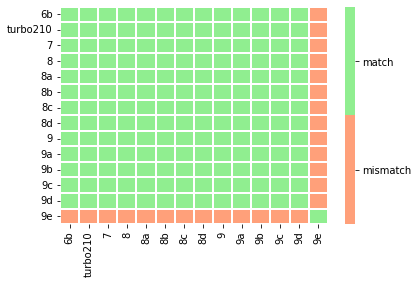

1


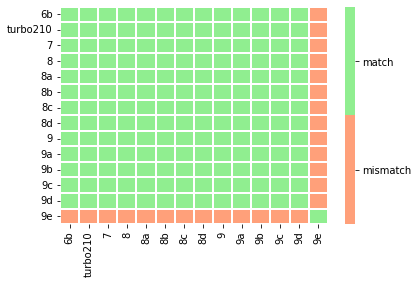

2


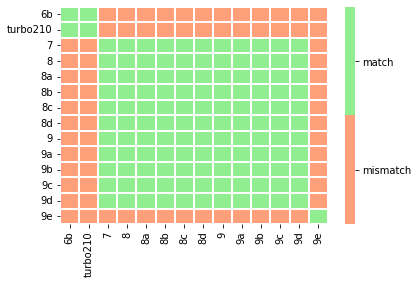

3


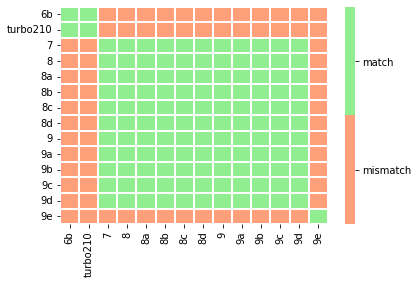

4


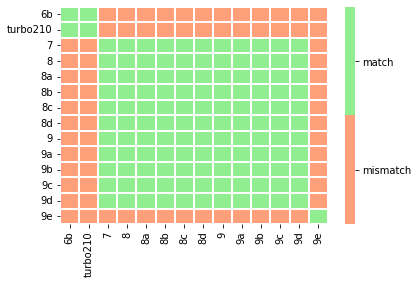

5


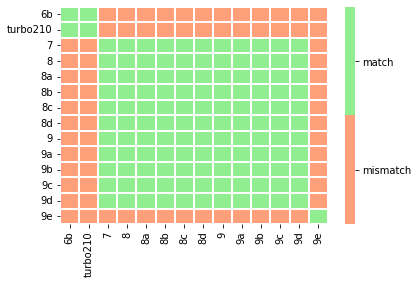

6


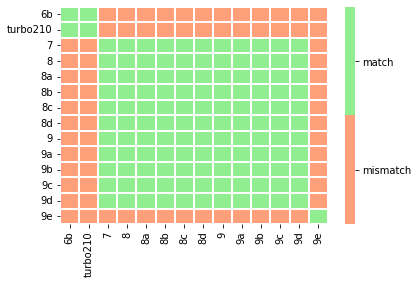

7


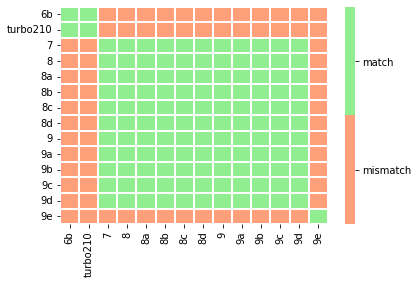

8


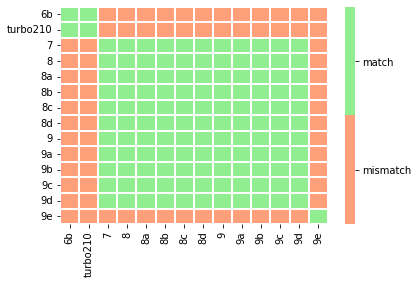

9


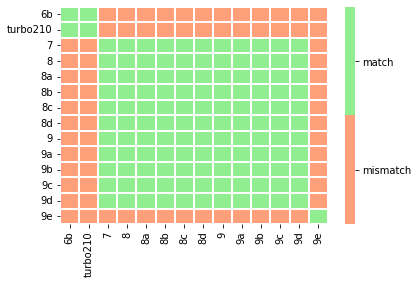

10


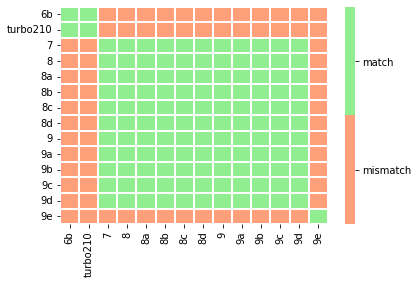

11


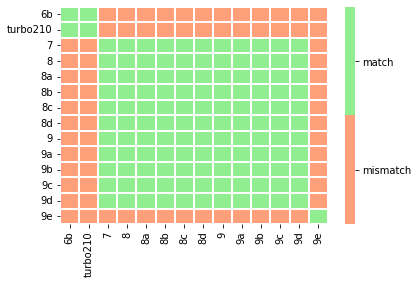

12


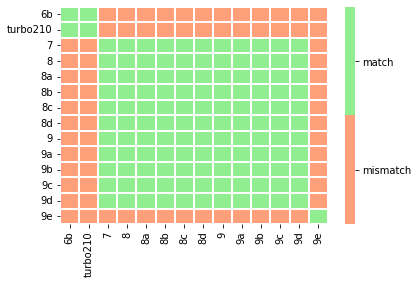

13


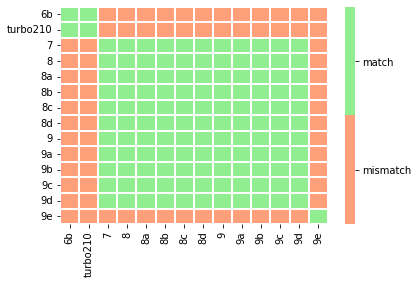

14


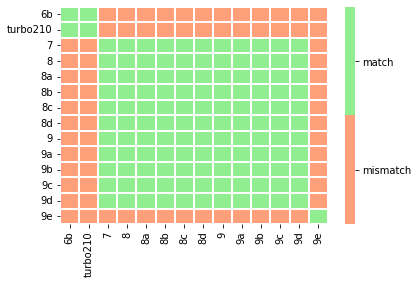

15


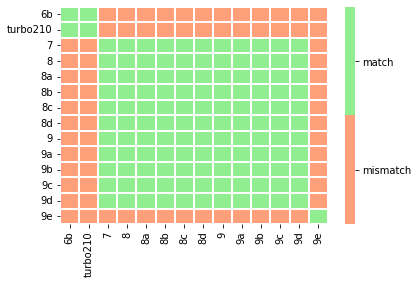

16


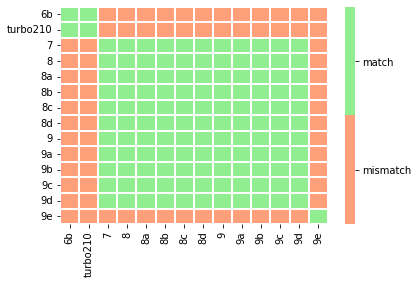

17


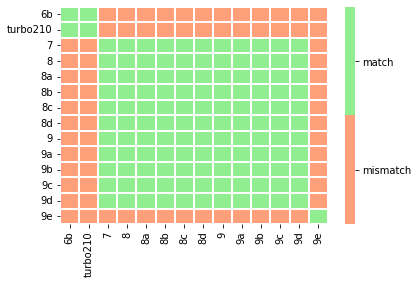

18


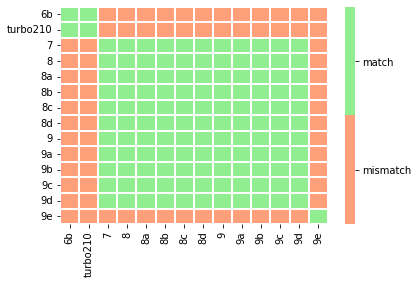

19


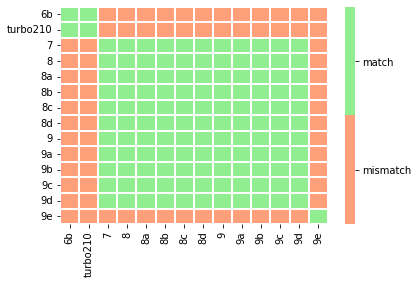

20


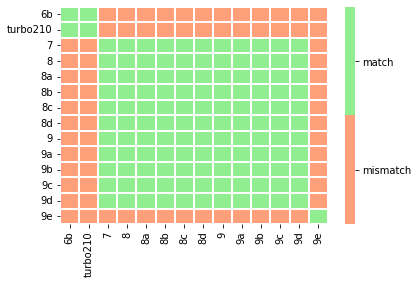

21


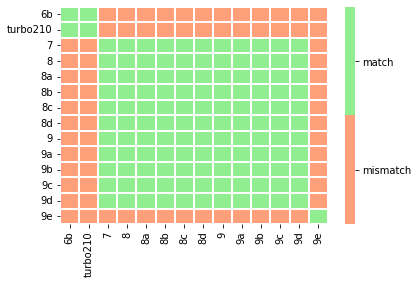

22


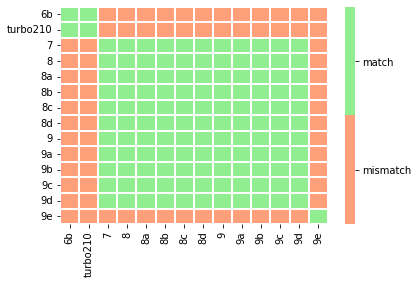

23


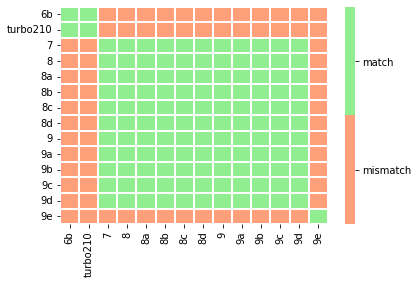

24


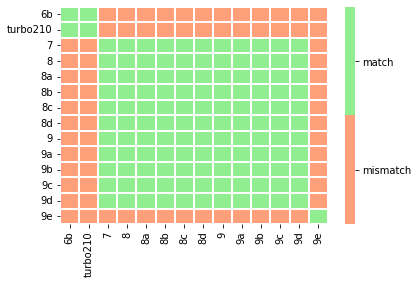

25


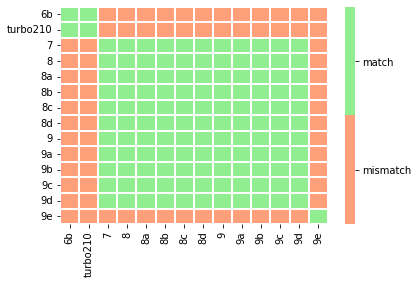

26


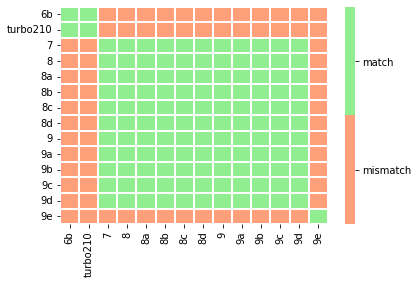

27


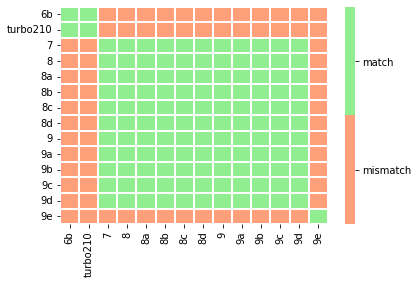

28


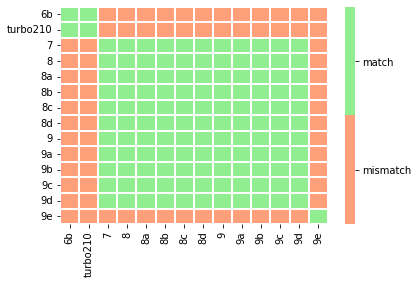

29


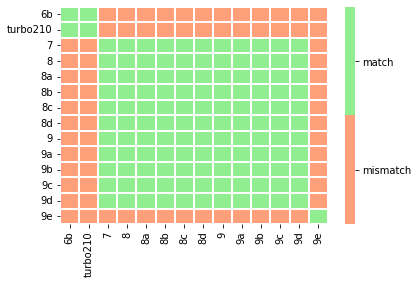

30


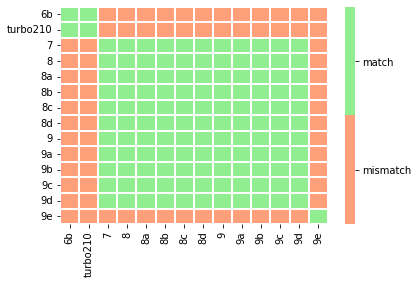

31


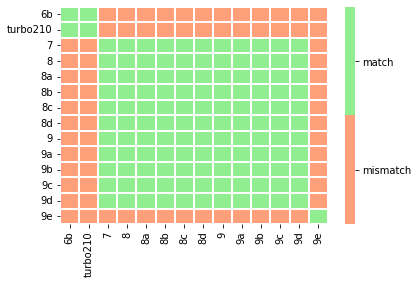

32


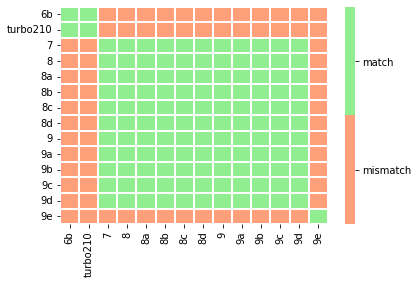

33


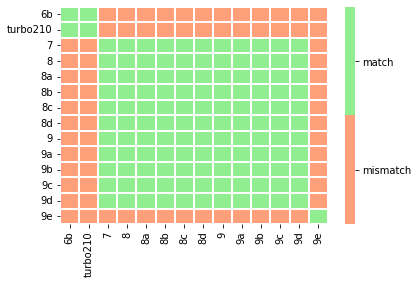

34


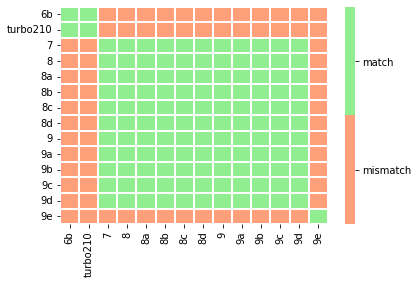

35


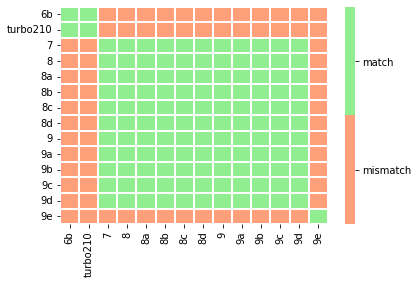

36


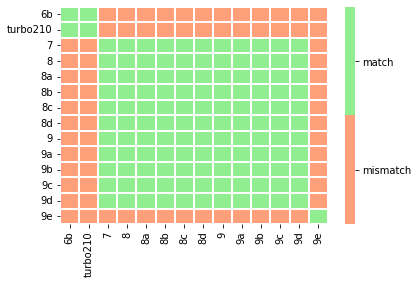

37


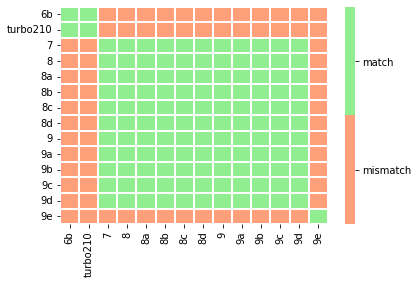

38


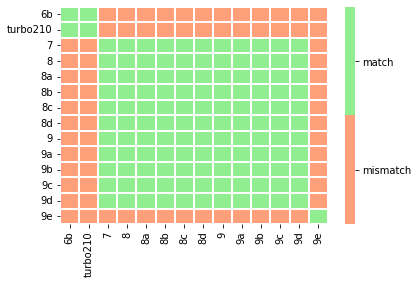

39


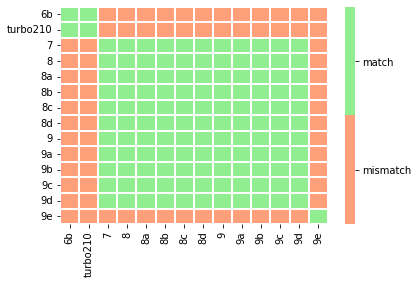

40


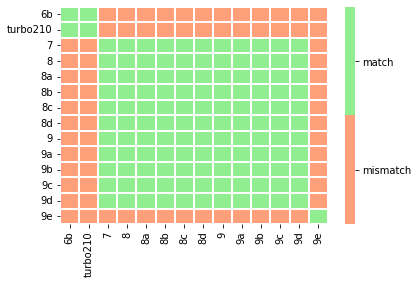

41


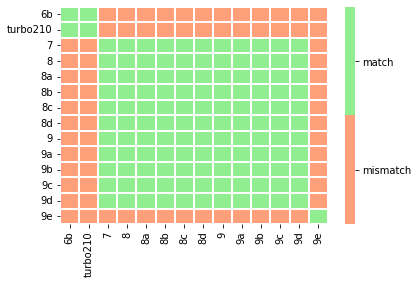

42


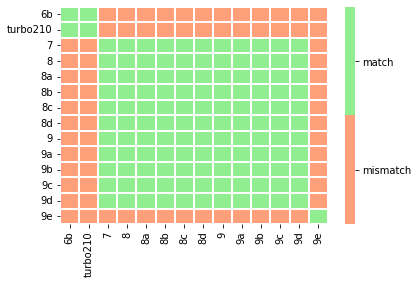

43


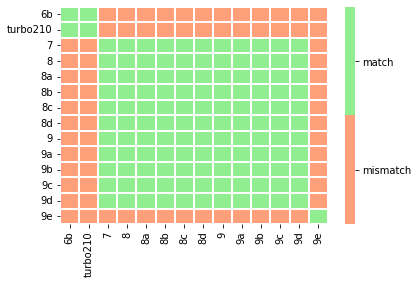

44


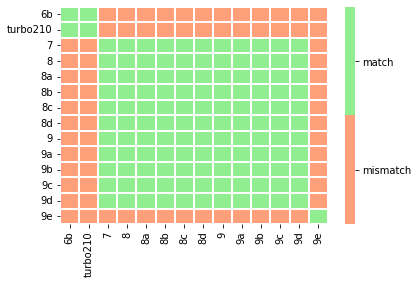

45


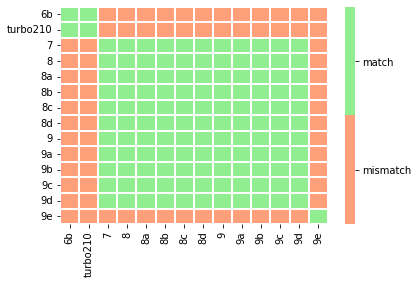

46


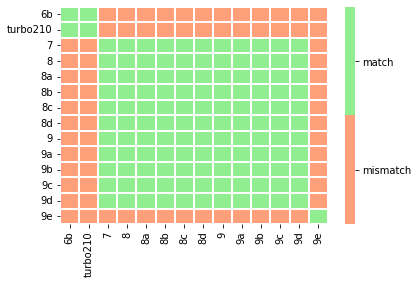

47


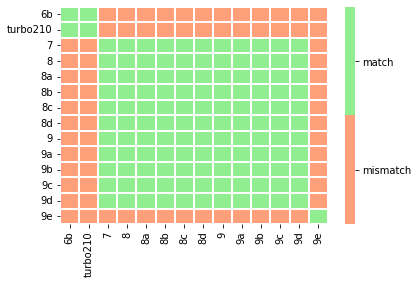

48


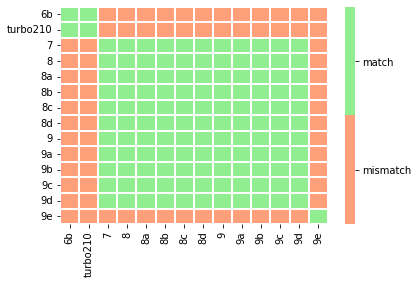

49


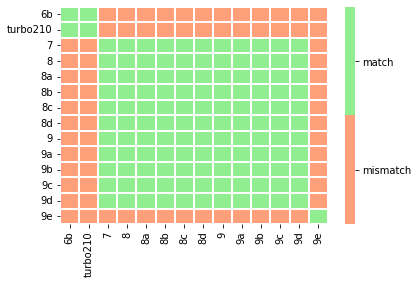

50


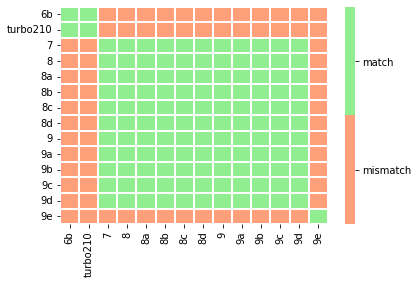

51


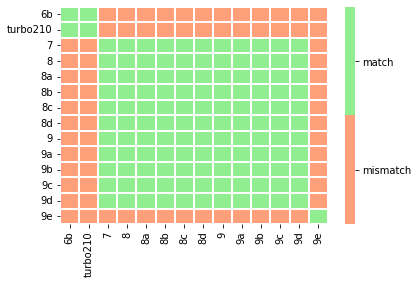

52


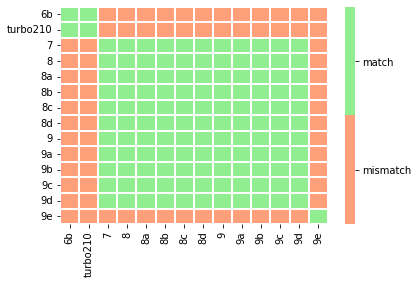

53


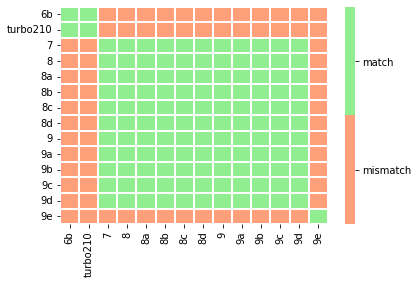

54


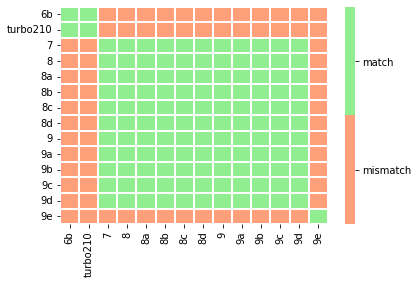

55


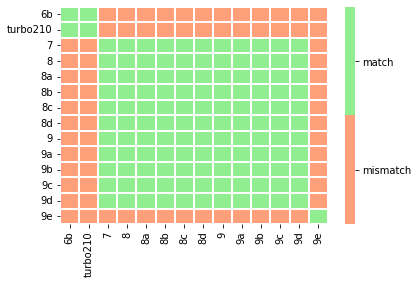

56


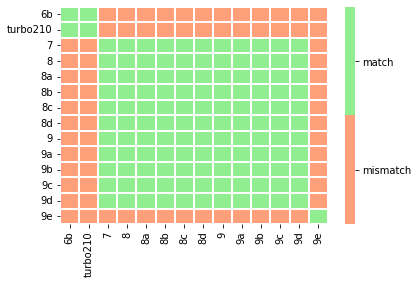

57


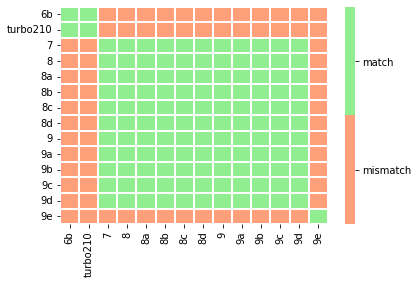

58


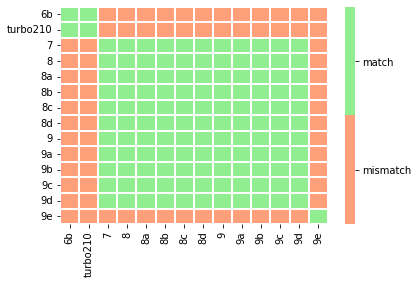

59


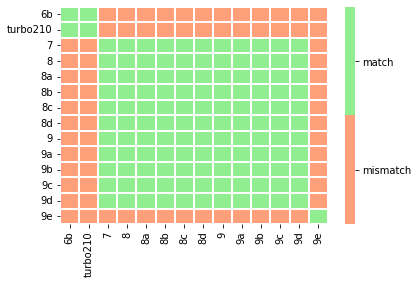

60


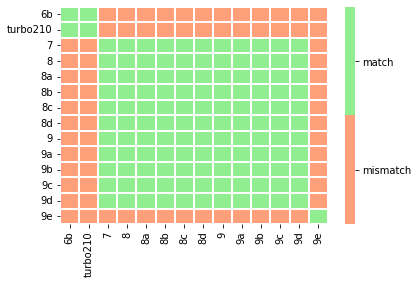

61


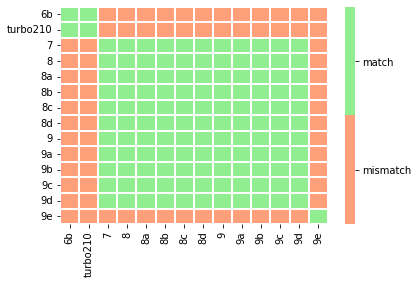

62


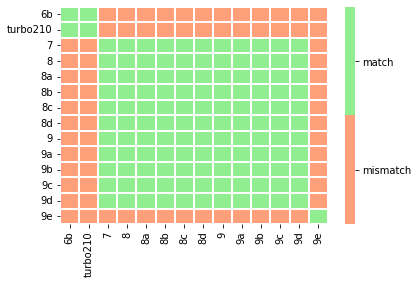

63


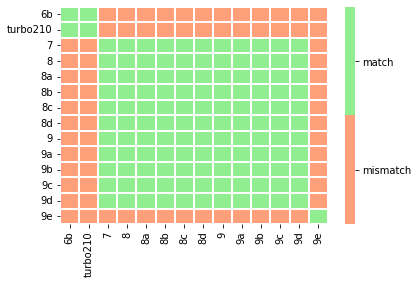

64


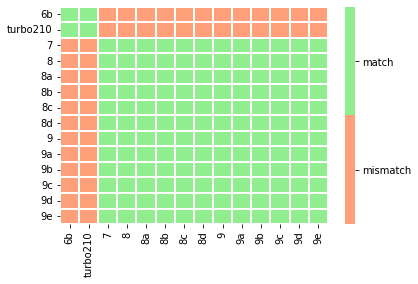

65


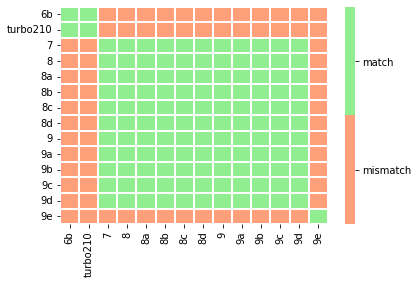

66


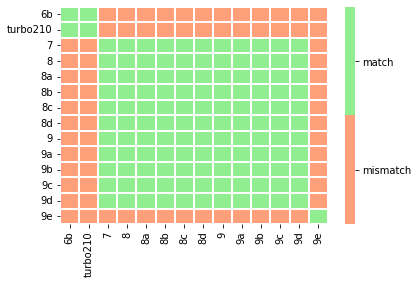

67


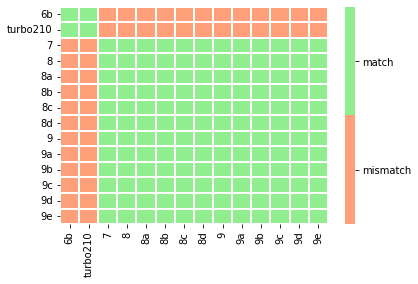

68


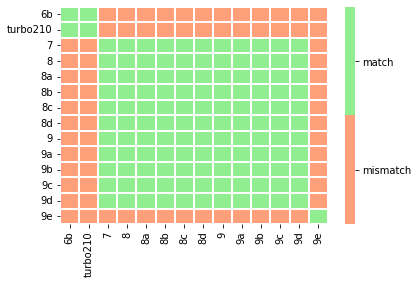

69


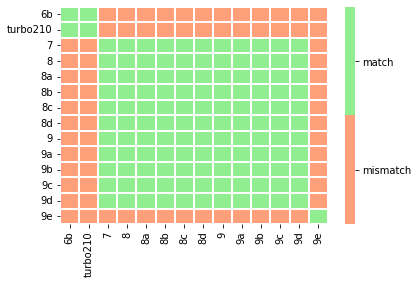

70


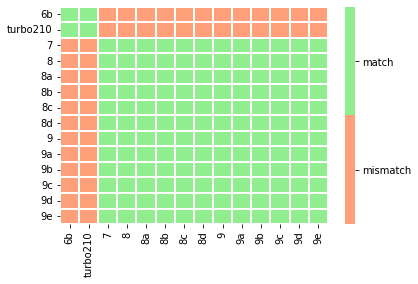

71


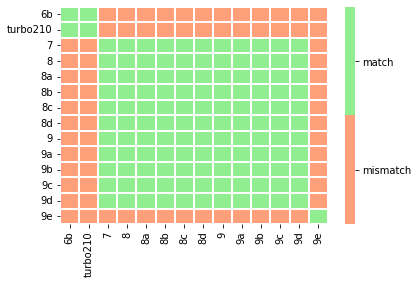

72


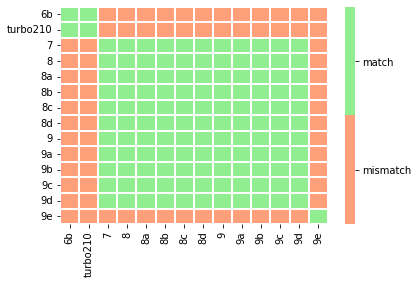

73


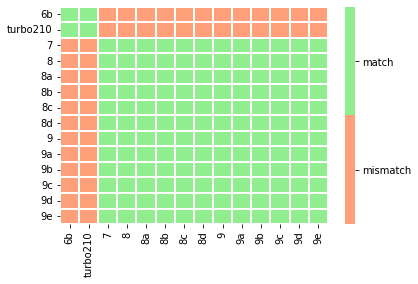

74


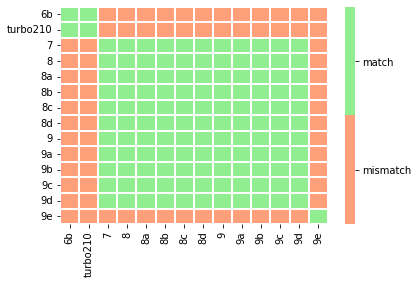

75


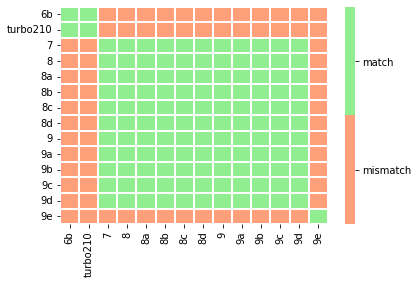

76


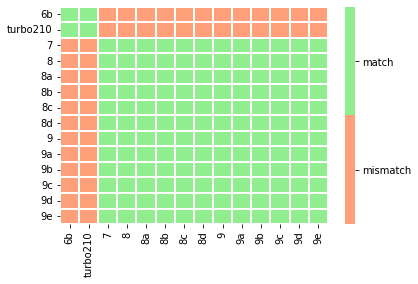

77


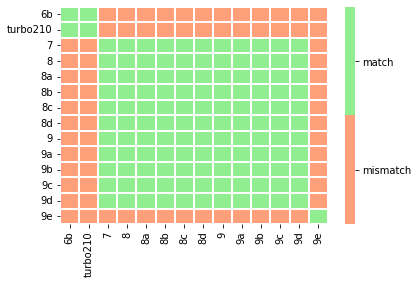

78


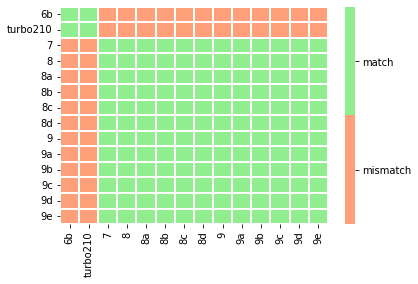

79


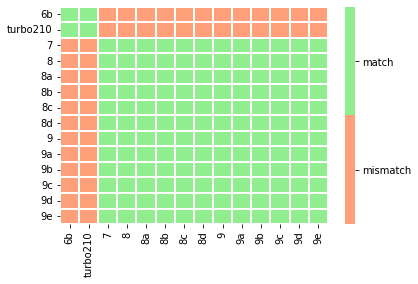

80


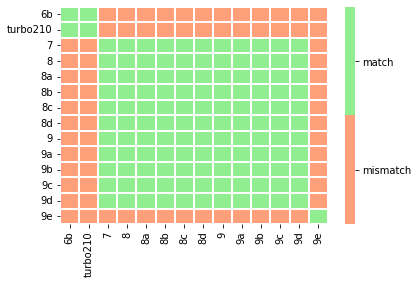

81


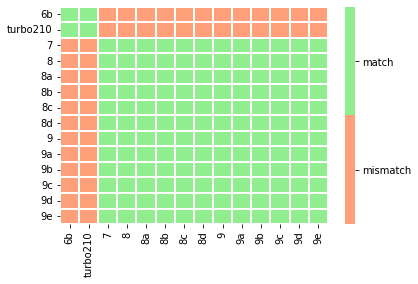

82


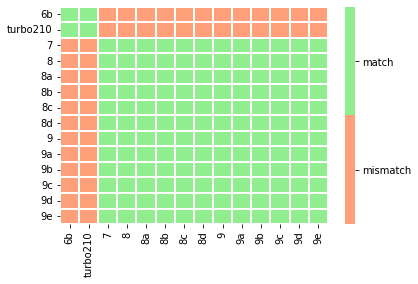

83


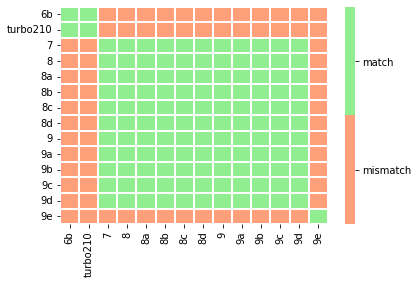

84


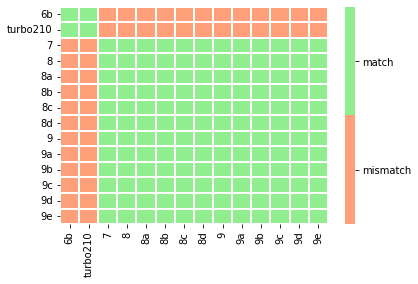

85


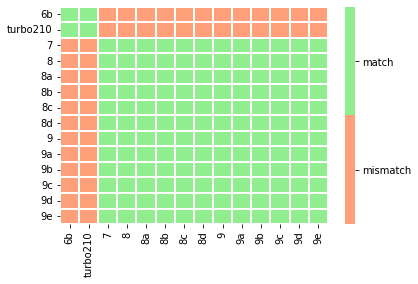

86


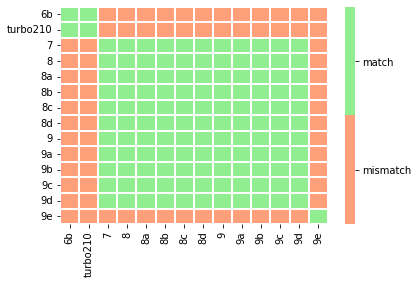

87


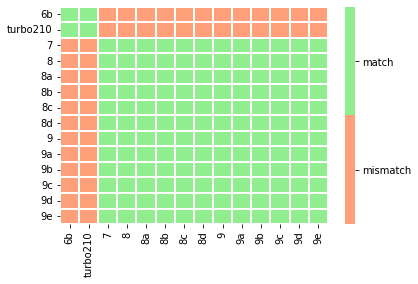

88


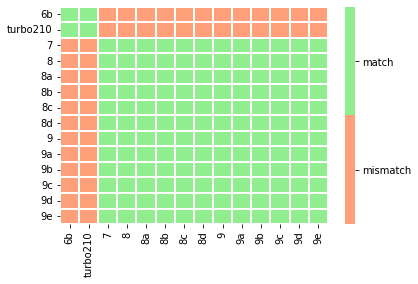

89


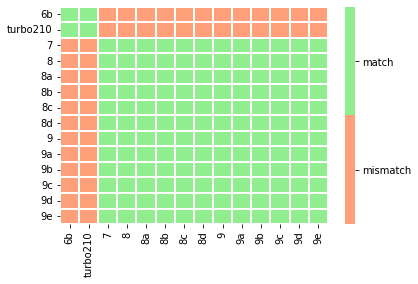

90


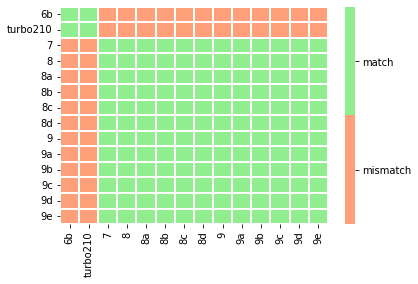

91


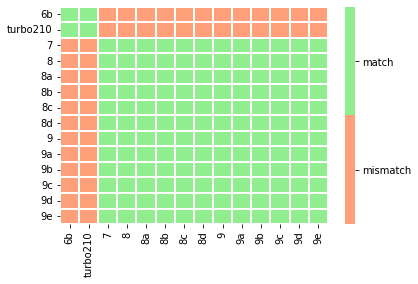

92


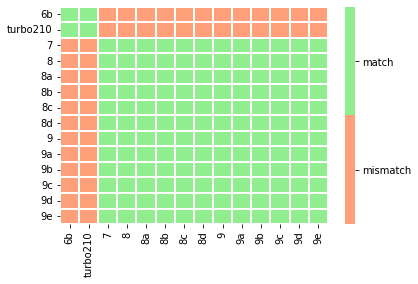

93


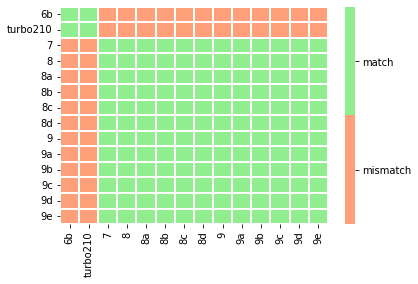

94


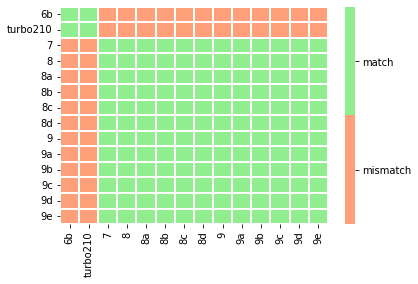

95


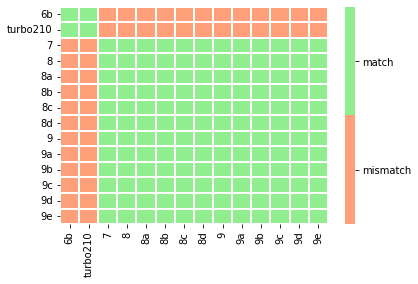

96


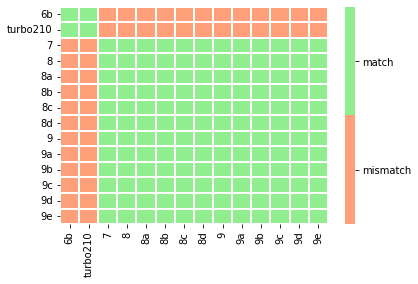

97


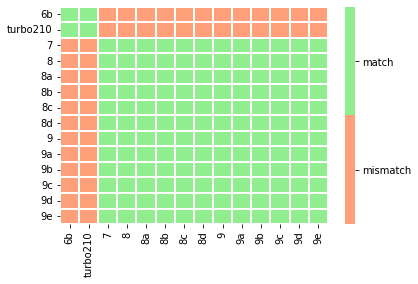

98


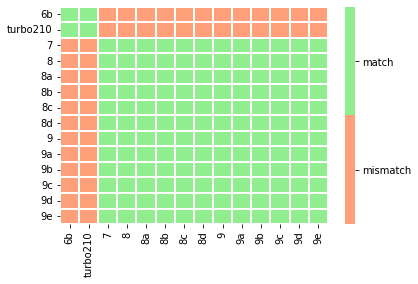

99


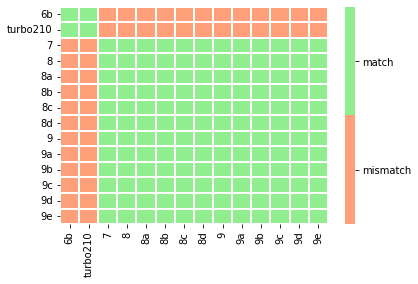

100


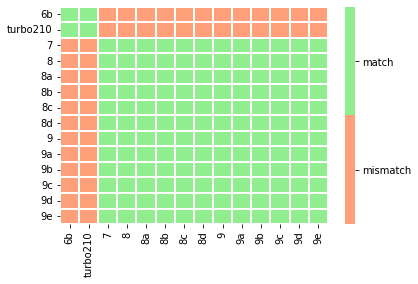

In [11]:
# create plot
import seaborn as sns
for quality in qualities:
    fig,ax = plt.subplots(1,1)
    sns.heatmap(
        pd.DataFrame(distmats_rgb_c[quality] == 0, index=versions, columns=versions),
        linewidth=.05, ax=ax, cmap=['lightsalmon','lightgreen'])
    colorbar = ax.collections[0].colorbar 
    r = colorbar.vmax - colorbar.vmin
    colorbar.set_ticks([colorbar.vmin + r / 2 * (0.5 + i) for i in range(2)])
    colorbar.set_ticklabels(['mismatch','match'])
    print(quality)
    plt.show();

Mismatch matrix supports the clusters discovered before.

### Decompression

In [12]:
# images recompressed by each version
images_rgb_d = {'version': [], 'quality': [], 'image': [], 'Y': [], 'Cb': [], 'Cr': []}
with tempfile.TemporaryDirectory() as tmp:
    
    # iterate versions
    for i,v_decompress in enumerate(versions):
        
        # iterate quality
        for quality in qualities:
        
            # compress each image with version
            fnames = [str(Path(tmp) / f'{i}.jpeg') for i in range(alaska.shape[0])]
            with jpeglib.version(v_arbitrary):
                for i,fname in enumerate(fnames):
                    im = jpeglib.from_spatial(alaska[i])
                    im.write_spatial(fname, qt=quality, flags=['+DO_FANCY_UPSAMPLING'])

            # decompress with single (arbitrary) version
            with jpeglib.version(v_decompress):
                images_rgb_d['version'].append(v_compress)
                images_rgb_d['quality'].append(quality)
                images_rgb_d['image'].append(np.array([
                    jpeglib.read_spatial(fname, flags=['+DO_FANCY_UPSAMPLING']).spatial for fname in fnames
                ]))
                images_rgb_d['Y'].append([
                    jpeglib.read_dct(fname).Y for fname in fnames
                ])
                images_rgb_d['Cb'].append([
                    jpeglib.read_dct(fname).Cb for fname in fnames
                ])
                images_rgb_d['Cr'].append([
                    jpeglib.read_dct(fname).Cr for fname in fnames
                ])
                
# dataframe
import pandas as pd
images_rgb_d = pd.DataFrame(images_rgb_d)

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution: quantization tables are too coarse for baseline JPEG
Caution:

In [13]:
# images to distance matrix
distmats_rgb_d = {}
for quality in qualities:
    print(quality, end=" ")
    images_rgb_d_ = images_rgb_d[images_rgb_d.quality == quality]
    
    images_rgb_d_list = np.array([list(i) for i in images_rgb_d_.image.to_list()], dtype=object)
    images_rgb_d_list = images_rgb_d_list.reshape(len(versions), -1)
    dists_rgb_d = pdist(images_rgb_d_list, mismatch)
    distmats_rgb_d[quality] = squareform(dists_rgb_d)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

In [14]:
# images to distance matrix
distmats_Y_d = {}
distmats_Cb_d = {}
distmats_Cr_d = {}
for quality in qualities:
    images_rgb_d_ = images_rgb_d[images_rgb_d.quality == quality]
    
    distmats_Y_d[quality] = get_distmat_dct(images_rgb_d_.Y)
    distmats_Cb_d[quality] = get_distmat_dct(images_rgb_d_.Cb)
    distmats_Cr_d[quality] = get_distmat_dct(images_rgb_d_.Cr)

    # check match with spatial
    print(
        quality,
        ((distmats_rgb[quality] == 0) == (distmats_Y[quality] == 0)).all(),
        ((distmats_rgb[quality] == 0) == (distmats_Cb[quality] == 0)).all(),
        ((distmats_rgb[quality] == 0) == (distmats_Cr[quality] == 0)).all()
    )

NameError: name 'distmats_rgb' is not defined

In [ ]:
# cluster
from sklearn.cluster import AgglomerativeClustering

for quality in qualities:
    for k in range(1,6):
        agnes = AgglomerativeClustering(n_clusters=k, linkage='average', affinity='precomputed')
        agnes.fit(distmats_rgb_d[quality])
    
        # compute heterogenity metric (sum of distances)
        heterogenity = np.sum([ distmats_rgb_d[quality][i,j]
                 for group in np.unique(agnes.labels_)
                 for i in np.where(agnes.labels_ == group)[0]
                 for j in np.where(agnes.labels_ == group)[0] ])
    
        # homogenous clusters
        if heterogenity == 0: break
    print("quality %d:" % quality, k, "classes:", *[[versions[i] for i in np.where(agnes.labels_ == cl)[0]] for cl in np.unique(agnes.labels_)])

## Grayscale images

Now we change to BOSS database, as we will work with grayscale images.

### Compression

First we compress with parameter `in_color_space` set to grayscale.

In [ ]:
# images recompressed by each version
import tempfile
images_gray_c = {'version': [], 'quality': [], 'image': [], 'Y': []}

with tempfile.TemporaryDirectory() as tmp:
    
    # iterate versions
    for i,v_compress in enumerate(versions):
        
        # iterate quality
        for quality in qualities:
        
            # compress each image with version
            fnames = [str(Path(tmp) / f'{i}.jpeg') for i in range(alaska.shape[0])]
            with jpeglib.version(v_compress):
                for i,fname in enumerate(fnames):
                    im = jpeglib.from_spatial(boss[i])
                    im.write_spatial(fname, qt=quality, flags=['+DO_FANCY_UPSAMPLING'])
        
            # decompress with single (arbitrary) version
            with jpeglib.version(v_arbitrary):
                images_gray_c['version'].append(v_compress)
                images_gray_c['quality'].append(quality)
                images_gray_c['image'].append(np.array([
                    jpeglib.read_spatial(fname, flags=['+DO_FANCY_UPSAMPLING']).spatial for fname in fnames
                ]))
                images_gray_c['Y'].append(np.array([
                    jpeglib.read_dct(fname).Y for fname in fnames
                ]))

# dataframe
import pandas as pd
images_gray_c = pd.DataFrame(images_gray_c)

### N-to-N comparison

Then we compare all the versions and construct distance matrix.

In [ ]:
# images to distance matrix
distmats_gray_c = {}
distmats_Y_c = {}
for quality in qualities:
    images_gray_c_ = images_gray_c[images_gray_c.quality == quality]
    
    images_gray_c_list = np.array([list(i) for i in images_gray_c_.image.to_list()], dtype=object)
    images_gray_c_list = images_gray_c_list.reshape(len(versions), -1)
    dists_gray_c = pdist(images_gray_c_list, pixel_mismatch)
    distmats_gray_c[quality] = squareform(dists_gray_c)
    
    #distmats_Y_c[quality] = get_distmat_dct(images_gray_c_.Y)

    
    print(
        quality,
        #((distmats_gray_c[quality] == 0) == (distmats_Y_c[quality] == 0)).all()
    )

### Clustering

The distance matrix is clustered based, so that we have uniform clusters.

In [ ]:
# cluster
from sklearn.cluster import AgglomerativeClustering
for quality in qualities:
    for k in range(1,6):
        agnes = AgglomerativeClustering(n_clusters=k, linkage='average', affinity='precomputed')
        agnes.fit(distmats_gray_c[quality])
    
        # compute heterogenity metric (sum of distances)
        heterogenity = np.sum([ distmats_gray_c[quality][i,j]
                 for group in np.unique(agnes.labels_)
                 for i in np.where(agnes.labels_ == group)[0]
                 for j in np.where(agnes.labels_ == group)[0] ])
    
        # homogenous clusters
        if heterogenity == 0: break
    print(quality, ':', k, "classes:", *[[versions[i] for i in np.where(agnes.labels_ == cl)[0]] for cl in np.unique(agnes.labels_)])

All the versions belong to the same cluster.

### Mismatch matrix

For control, we again plot the mismatch matrix.

In [ ]:
# create plot
import seaborn as sns
for quality in qualities:
    fig,ax = plt.subplots(1,1)
    sns.heatmap(
        pd.DataFrame(distmats_gray[quality] == 0, index=versions, columns=versions),
        linewidth=.05, ax=ax, cmap=['lightsalmon','lightgreen'])
    colorbar = ax.collections[0].colorbar
    r = colorbar.vmax - colorbar.vmin 
    colorbar.set_ticks([colorbar.vmin + r / 2 * (0.5 + i) for i in range(2)])
    colorbar.set_ticklabels(['mismatch','match'])
    plt.show();

Heatmap shows that every version's output matches with every other.